In [1]:
import sys
sys.path.append("..")
from src.query_funcs import *
from src.analysis_funcs import *
import pandas as pd
import numpy as np
import random as rand

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


### Conteo de productos por supermercado

Comencemos por un análisis simple, contando los artículos individuales de cada uno de los supermercados.

In [2]:
conexion = conectar()
result = query_fetch(conexion, query_text='''select s.nombre AS nombre_supermercado,
	c.nombre as nombre_categoria,
    count(distinct p.nombre) as n_productos
from productos p
join supermercado s on p.id_supermercado = s.id_supermercado
join subcategorias sc on sc.id_subcat = p.id_subcat 
join categorias c on c.id_categoria = sc.id_categoria 
group by
    s.nombre, c.nombre
order by 
    n_productos DESC;''')

result_df = pd.DataFrame(result)
result_df.rename(columns=dict(enumerate(["Supermercado", "Categoria", "N de productos"])), inplace=True)


In [3]:
px.bar(result_df, x = "Supermercado", y = "N de productos",
        color="Categoria", title ="Conteo de artículos por supermercado",
        color_discrete_sequence=px.colors.qualitative.Vivid)

Vemos que el Hipercor es el que mayor variedad de productos ofrece, mientras que Mercadona el que menos. Todo esto teniendo en cuenta las limitadas secciones que provee Facua en su web, pero la muestra que tenemos nos da información de productos con mucha relevancia, lo cual podría ser indicativo del resto de la oferta de cada uno de los supermercados.

### Precios por supermercado (a día de hoy)

Pasemos a analizar ahora los precios de los productos por tipo en cada supermercado. Tomaremos los resultados del día 26 de Octubre de 2024. No cogemos los del 27 ya que la web tiene muchos menos registros los domingos, reduciendo mucho la cantidad de datos disponibles.

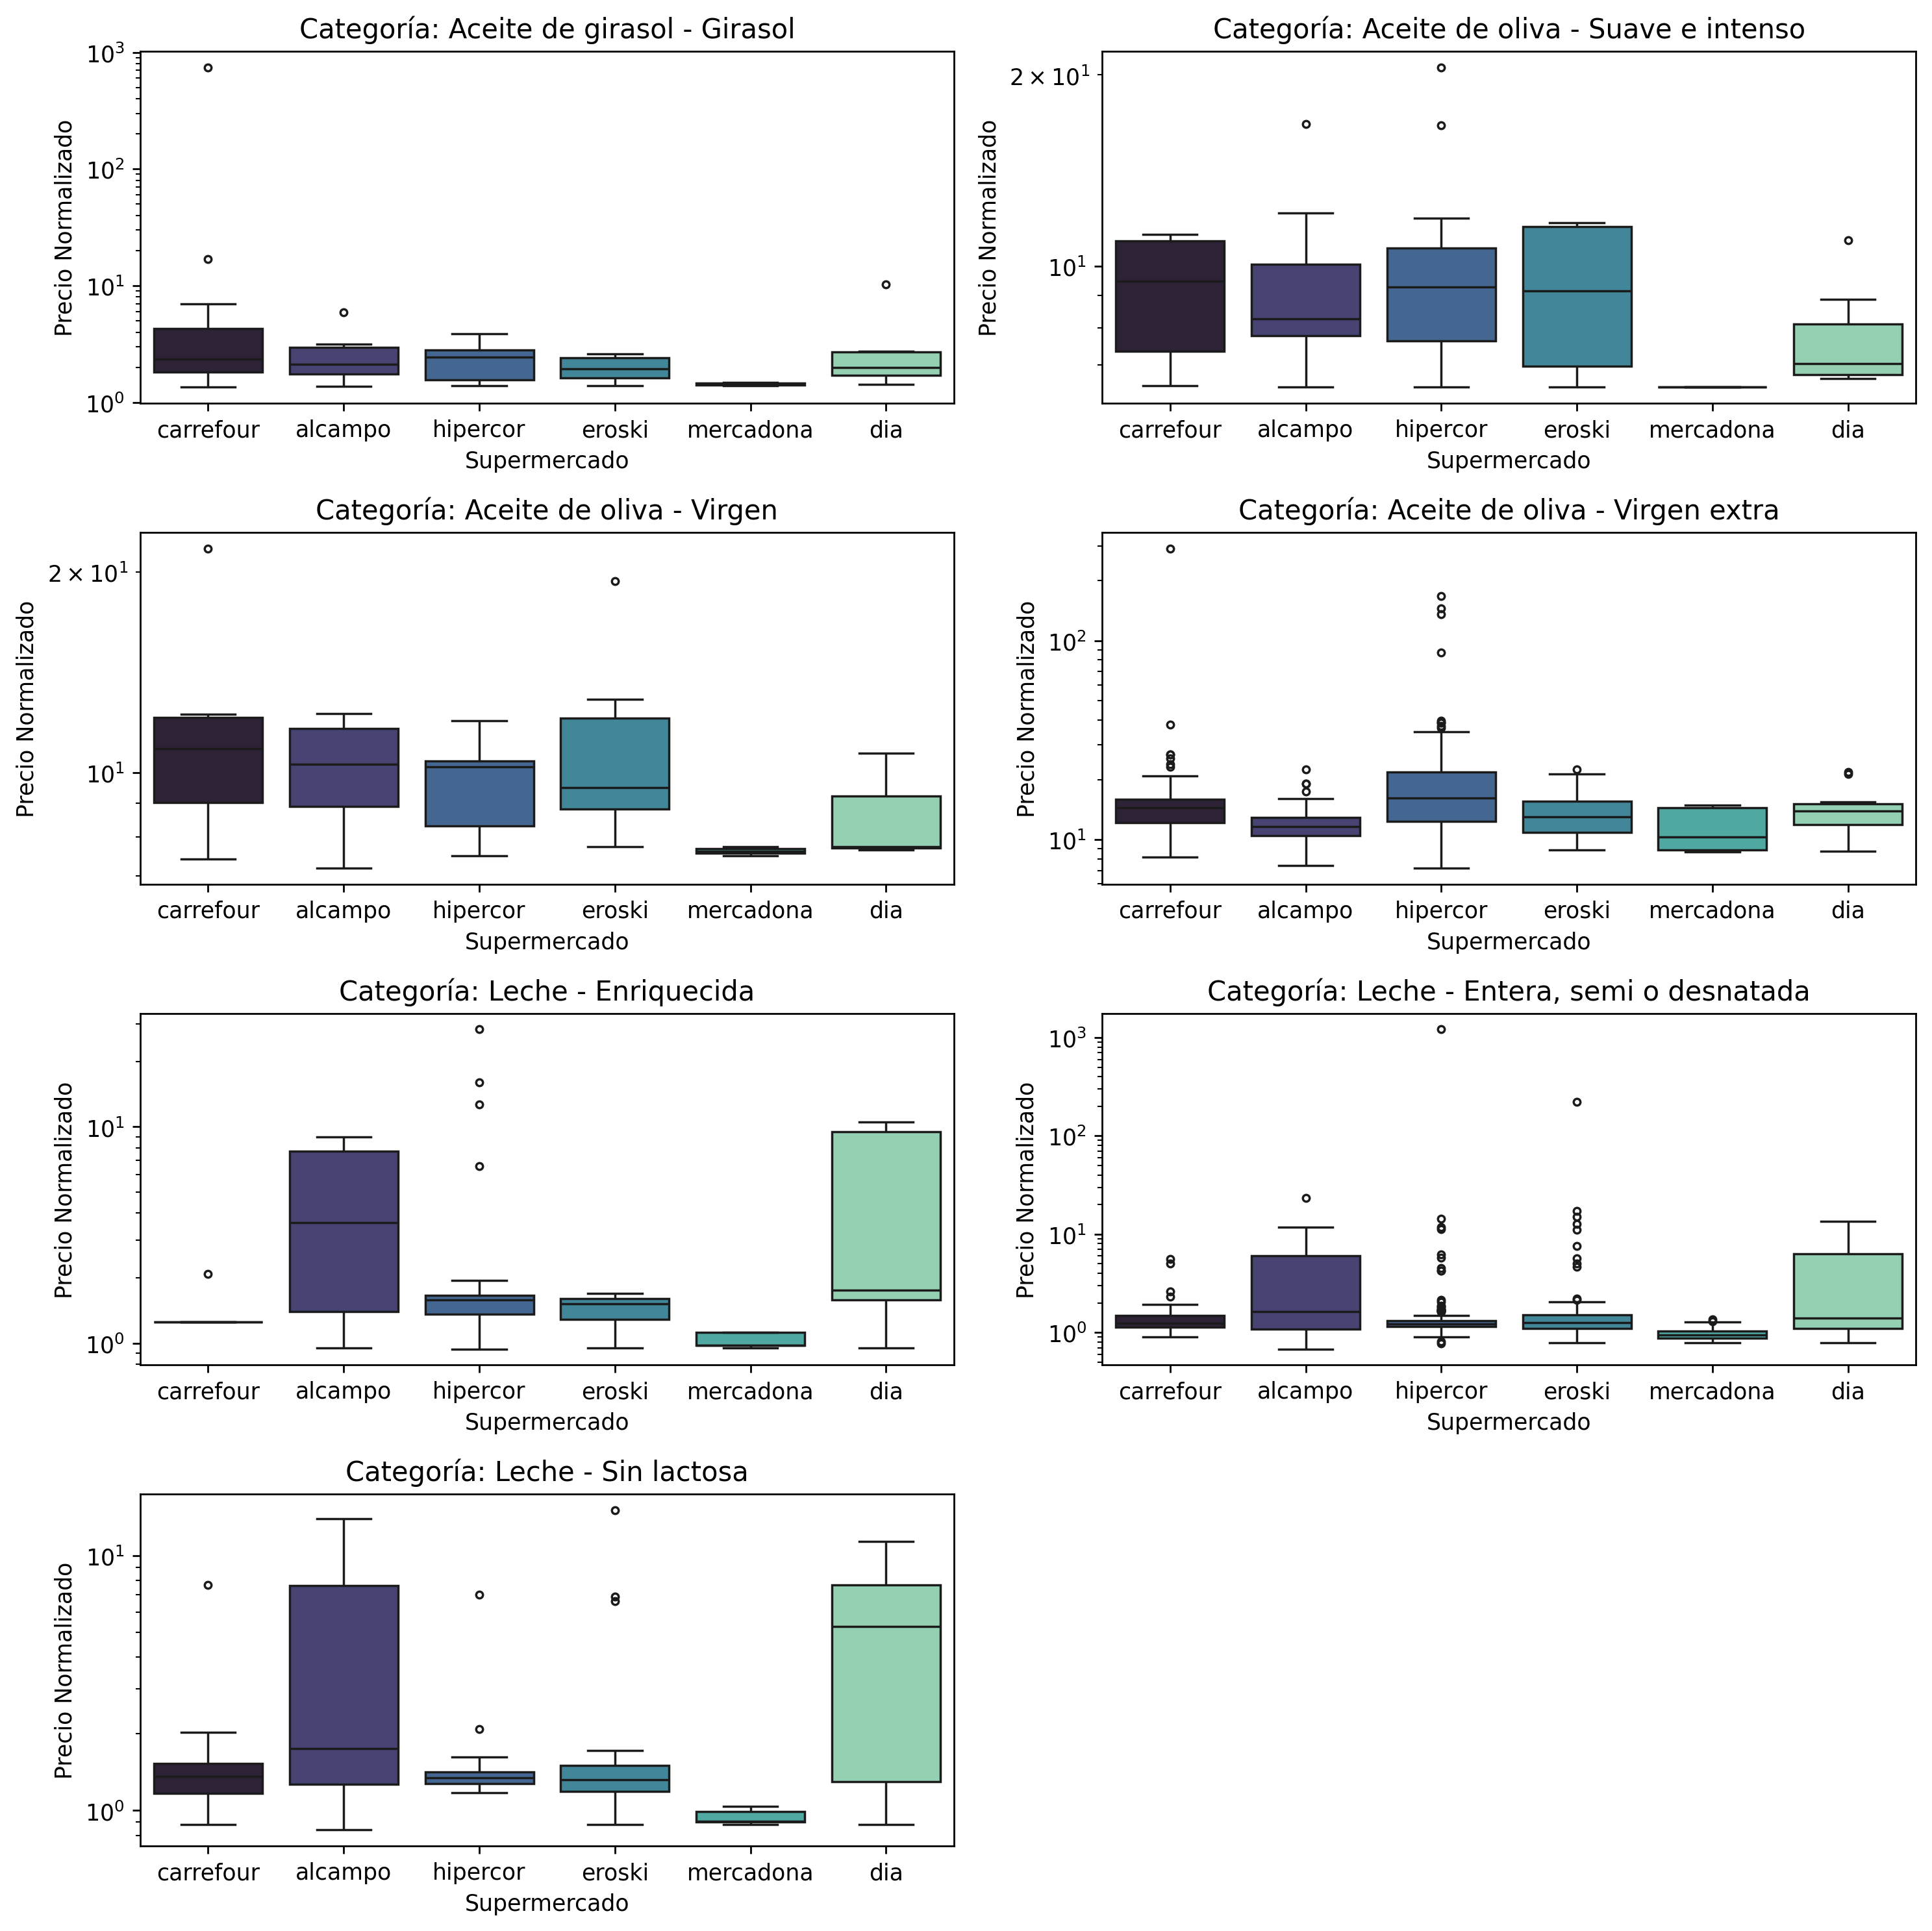

In [4]:
query = '''select 
    p.nombre as nombre_producto, 
    case 
        when p.cantidad is null then null
        when p.unidad = 'g' then (r.precio / p.cantidad) * 1000
        when p.unidad = 'l' THEN r.precio / p.cantidad
        else null
    end as precio_norm,
    c.nombre as categoria,
    s.nombre as subcategoria,
    s2.nombre as nombre_supermercado
from registros r
inner join productos p 
on p.id_producto = r.id_producto
inner join subcategorias s 
on p.id_subcat = s.id_subcat 
inner join categorias c 
on c.id_categoria = s.id_categoria 
inner join supermercado s2 
on s2.id_supermercado = p.id_supermercado 
where r.fecha = '2024-10-26'
order by categoria, subcategoria;''' #! Previamente la query era con 
                                     #!(SELECT MAX(r2.fecha) FROM registros r2), sin embargo,
                                     #! Los domingos hay menos registros, por lo que se impuso una fecha específica

conexion = conectar()
precios_ps = pd.DataFrame(query_fetch(conexion, query), 
                          columns=["nombre_producto", "precio_norm", "categoria", "subcategoria", "supermercado"])

subcategorias = precios_ps["subcategoria"].unique() # Extraemos las subcategorías
supermercados_ordenados = precios_ps["supermercado"].unique() # Extraemos los supermercados, lo cual nos servirá para ordenar

fig, axes = plt.subplots(4, 2, figsize=(12, 12), dpi = 250)
axes = axes.flatten()

for i, subcategoria in enumerate(subcategorias):
    df_subcat = precios_ps[precios_ps["subcategoria"] == subcategoria]
    categoria = df_subcat["categoria"].iloc[0] # Categoría a la que pertenece la subcategoría de cada iteración
    
    sns.boxplot(data=df_subcat, y="precio_norm", x="supermercado", palette="mako", 
                order=supermercados_ordenados, ax=axes[i],  flierprops={"marker": "."})
    
    axes[i].set_title(f"Categoría: {categoria} - {subcategoria}")
    axes[i].set_ylabel("Precio Normalizado")
    axes[i].set_xlabel("Supermercado")
    axes[i].set_yscale("log") # Escala logarítmica ya que la presencia de atípicos arruina la escala lineal.
fig.delaxes(axes[7])
    
plt.tight_layout()
plt.show()


Con esta gráfica observamos varias cosas. Lo primero de todo, la cantidad relativamente alta de valores atípicos que obtenemos. Vamos a mirar primero de dónde proceden:

In [5]:
precios_ps["precio_norm"] = precios_ps["precio_norm"].astype(float)

Aceites de girasol:

In [6]:
for sm in precios_ps["supermercado"].unique():
    print(precios_ps.iloc[get_outliers_especificos(precios_ps, sm, "Girasol").index]["nombre_producto"].values)

['Aceite de girasol Koipe Sol spray 150 ml. en Carrefour'
 'Ozolife Aceite Girasol Ozonizado Air-less 50 Ml en Carrefour']
['CAMPOMAR NATURE Aceite de girasol ecológico CAPOMAR 1 l. en Alcampo']
[]
[]
[]
['Aceite de girasol alto oleico especial freidora de aire Diasol spray 200 ml en Dia']


Son todos formatos pequeños, lo cual hace que sus precios normalizados se disparen. Aún así se ovserva una relativa similitud de precios (no atípicos) entre supermercados.

Aceites de oliva:

In [7]:
oliva_outliers = []
oliva_subcats = precios_ps[precios_ps["categoria"] == "Aceite de oliva"]["subcategoria"].unique()
for subcat in oliva_subcats:
    for sm in precios_ps["supermercado"].unique():
        oliva_outliers.extend(precios_ps.iloc[get_outliers_especificos(precios_ps, sm, subcat).index]["nombre_producto"].values)

In [8]:
oliva_outliers

['CARBONELL Aceite de oliva spray especial plancha  Sabor bote de 200 ml. en Alcampo',
 'CARBONELL aceite de oliva suave 0,4º pack 2 botellas 1 l en Hipercor',
 'CARBONELL aceite de oliva suave 0,4º Original para plancha y horno spray 200 ml en Hipercor',
 'Aceite de oliva suave La española botella 1 l en Dia',
 'Aceite de oliva virgen plancha y horno Carbonell 200 ml. en Carrefour',
 'Aceite de oliva virgen plancha y airfryer CARBONELL, spray 20 cl en Eroski',
 'Aceite de oliva virgen extra Marqués de Griñón 500 ml. en Carrefour',
 'Aceite de oliva virgen extra Nuñez de Prado 500 ml. en Carrefour',
 'Aceite de oliva virgen extra picual ecológico Oro Bailén 500 ml. en Carrefour',
 'Aceite de oliva virgen extra picual Oro Bailén 500 ml. en Carrefour',
 'Aceite de oliva virgen extra arbequina Oro Bailén 500 ml. en Carrefour',
 'Aceite de oliva virgen extra Capricho Andaluz pack de 10 porciones de 10 ml. en Carrefour',
 'Aceite de oliva virgen extra Carbonell 200 ml. en Carrefour',
 'ORO 

Aquí sucede como con los de girasol, formatos pequeños que provocan que los precios normalizados (por L) se disparen. Igual que antes, se observan precios (no atípicos) cercanos.

Leche:

In [9]:
leche_outliers = []
leche_subcats = precios_ps[precios_ps["categoria"] == "Leche"]["subcategoria"].unique()
for subcat in leche_subcats:
    for sm in precios_ps["supermercado"].unique():
        leche_outliers.extend(precios_ps.iloc[get_outliers_especificos(precios_ps, sm, subcat).index]["nombre_producto"].values)

In [10]:
rand.sample(leche_outliers, k = 10)

['PULEVA leche semidesnatada ecológica sin lactosa brik 1 l en Hipercor',
 'KAIKU SIN LACTOSA leche semidesnatada enriquecida con calcio + Vitamina D sin lactosa pack 3 briks 200 ml en Hipercor',
 'Leche en polvo Desnatada SVELTESSE, lata 400 g en Eroski',
 'Leche Evaporizada IDEAL, porciones, pack 10x7,5 g en Eroski',
 'SEÑORIO DE SARRIA leche entera fresca botella 1 l en Hipercor',
 'ASTURIANA leche en polvo entera estuche 800 g en Hipercor',
 'Leche entera Hacendado 1.2 l. en Mercadona',
 'LARSA leche entera de pastoreo botella 1,5 ml en Hipercor',
 'ASTURIANA leche entera pack 6 briks 200 ml en Hipercor',
 'NESTLE SVELTESSE leche desnatada en polvo rica en calcio bote 1 kg en Hipercor']

Vemos que con las leches hay un patrón recurrente. Debido a nuestra forma de recopilar datos, la información de packs se ha perdido, obteniendo solo el volumen de la unidad. Luego, al normalizar los precios, estos se elevan debido a ello, por lo que son valores atípicos resultantes de una extracción de datos errónea.

Además de esto, también encontramos valores atípicos en productos como la leche en polvo. 

Por último hay un caso especial, asociado al supermercado Hipercor, donde vemos que el precio de un atípico supera los 1000 €. Esto se debe a un error en la página a la hora de nombrar el producto: 'LARSA leche entera de pastoreo botella 1,5 ml en Hipercor'. Claramente este producto es una botella de 1.5 Litros, no mililitros. Esto hace que al normalizar el precio se dispare hasta un valor tan elevado.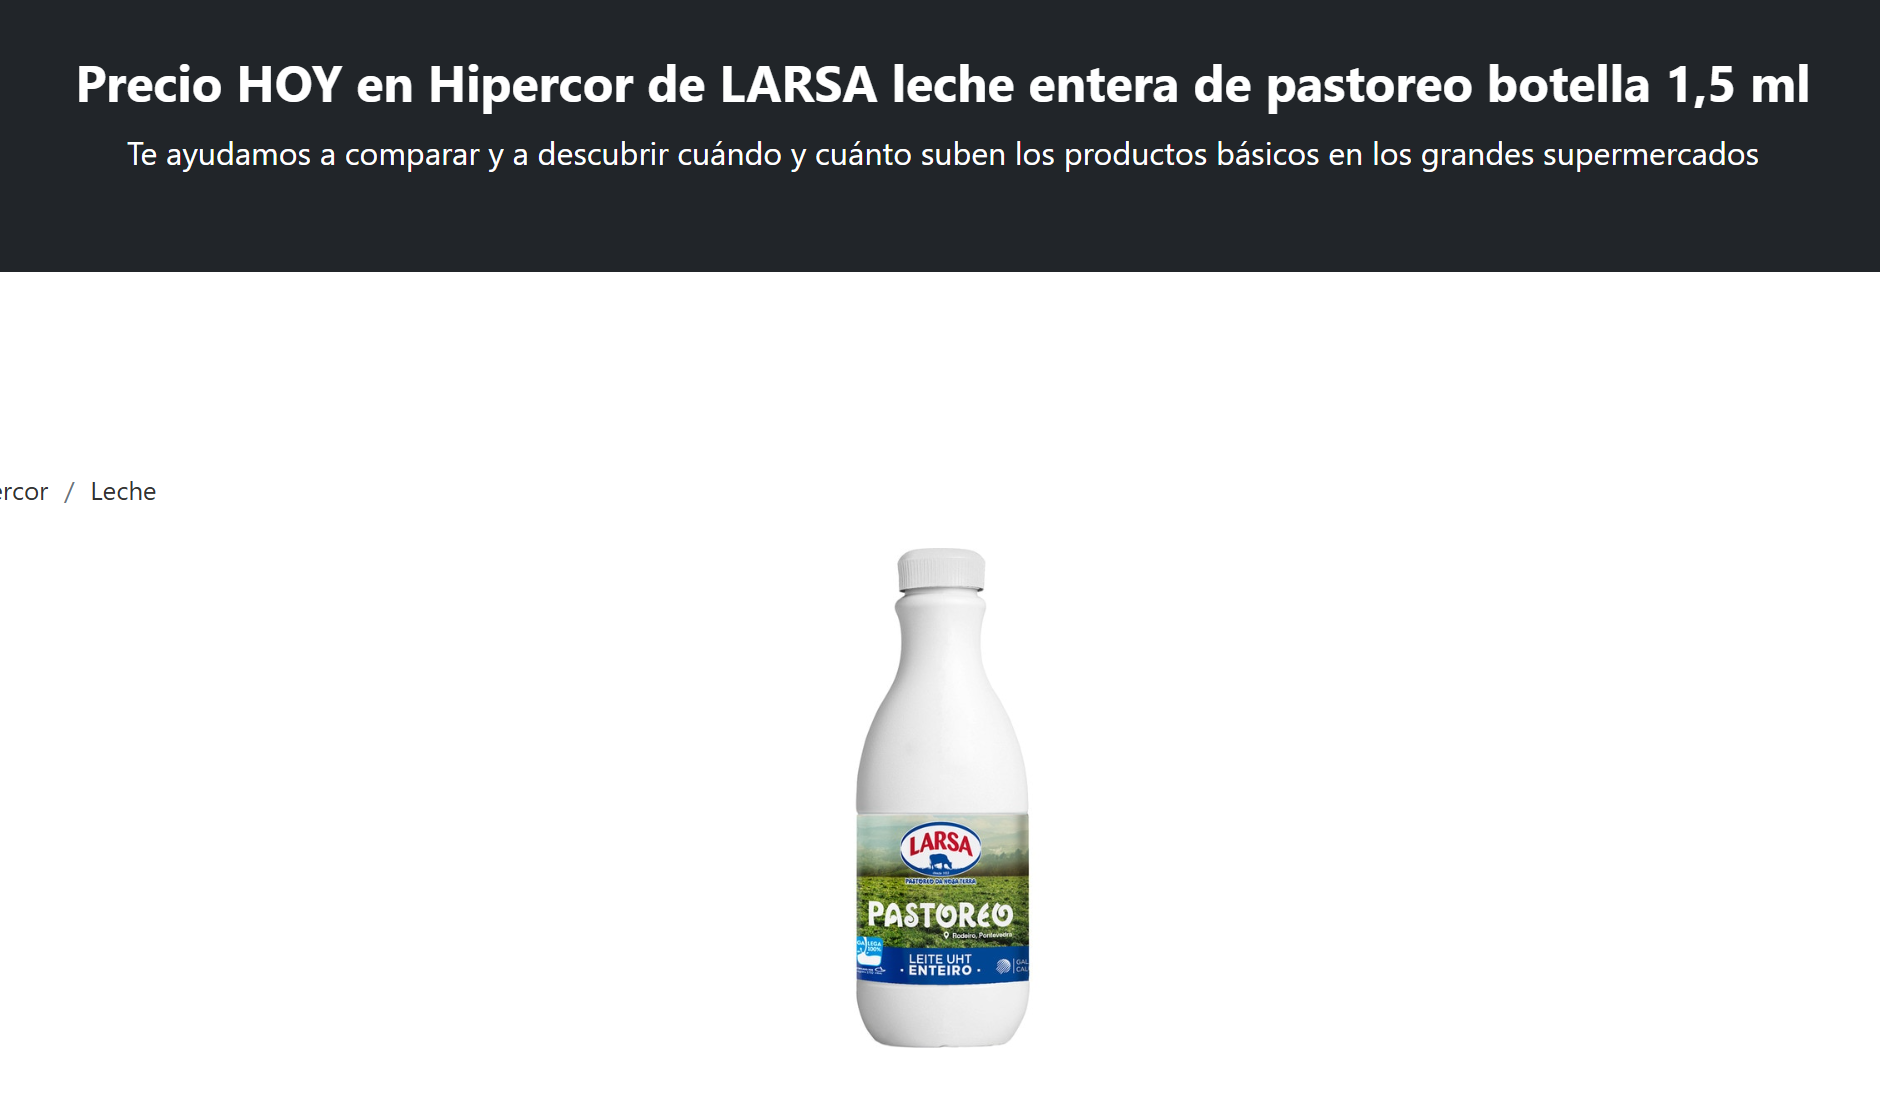

El caso de Mercadona también es algo a destacar, ya que observamos que sus precios están contenidos todos en un rango bastante estrecho, lo cual tiene sentido, ya que al ofrecer una menor cantidad de productos, y estos siendo de la propia marca del establecimiento, tiene una menor variedad de gamas de precios, lo cual provoca que los precios no tengan una dispersión tan alta como la hay en los demás supermercados.

Puede que los valores atípicos superiores nos hicieran ver que cada supermercado presenta precios muy diferentes al resto, debido a que esto ocurre por productos de otras marcas o simplemente errores de extracción. Sin embargo si miramos en el otro lado del espectro, los valores mínimos, vemos que presentan una menor variación de un supermercado a otro. 

Veamos en qué supermercado se presentan los menores y mayores precios.

In [11]:
resultados_min = []

subcategorias = precios_ps["subcategoria"].unique()
for subcategoria in subcategorias:
    df_subcat = precios_ps[precios_ps["subcategoria"] == subcategoria]
    categoria = df_subcat["categoria"].iloc[0]

    for sm in precios_ps["supermercado"].unique():
        minimo = get_min(precios_ps, sm, subcategoria)

        resultados_min.append({
            "categoria": categoria,
            "subcategoria": subcategoria,
            "supermercado": sm,
            "nombre_producto": minimo["nombre_producto"],
            "precio_minimo_norm": minimo["precio_norm"]
        })

df_resultados_min = pd.DataFrame(resultados_min)

ids_min = df_resultados_min.groupby("subcategoria")["precio_minimo_norm"].idxmin()
precios_minimos = df_resultados_min.iloc[ids_min].reset_index(drop=True)
precios_minimos

,categoria,subcategoria,supermercado,nombre_producto,precio_minimo_norm
0,Leche,Enriquecida,hipercor,EL CORTE INGLES leche desnatada sin lactosa en...,0.94
1,Leche,"Entera, semi o desnatada",alcampo,TIERRA DE SABOR Leche entera de vaca 1 l. en A...,0.68
2,Aceite de girasol,Girasol,carrefour,Aceite de girasol para freír Carrefour garrafa...,1.35
3,Leche,Sin lactosa,alcampo,"L.R. Leche desnatada de vaca, sin lactosa 1l. ...",0.84
4,Aceite de oliva,Suave e intenso,alcampo,PRODUCTO ALCAMPO Aceite de oliva suave garrafa...,6.45
5,Aceite de oliva,Virgen,alcampo,COOSUR Aceite de oliva virgen cocina Mediterrá...,7.19
6,Aceite de oliva,Virgen extra,hipercor,EL CORTE INGLES aceite de oliva intenso 1º con...,7.19


In [12]:
precios_minimos["nombre_producto"].values

array(['EL CORTE INGLES leche desnatada sin lactosa enriquecida con vitaminas A, D, E y B9 brik 1 l en Hipercor',
       'TIERRA DE SABOR Leche entera de vaca 1 l. en Alcampo',
       'Aceite de girasol para freír Carrefour garrafa 5 l. en Carrefour',
       'L.R. Leche desnatada de vaca, sin lactosa 1l. en Alcampo',
       'PRODUCTO ALCAMPO Aceite de oliva suave garrafa de 5 l. en Alcampo',
       'COOSUR Aceite de oliva virgen cocina Mediterránea garrafa de 5 l. en Alcampo',
       'EL CORTE INGLES aceite de oliva intenso 1º contiene aceites refinados, vírgenes y 50% de virgen extra garrafa 5 l en Hipercor'],
      dtype=object)

En cuanto vemos los más baratos vemos una clara tendencia en los formatos de los aceites. Ya que el precio está normalizado, lo más barato es comprar formatos de mayor volumen, lo cual reduce el precio por litro. 

En general, los productos de menor precio se encuentran en Alcampo.

In [13]:
resultados_max = []

subcategorias = precios_ps["subcategoria"].unique()
for subcategoria in subcategorias:
    df_subcat = precios_ps[precios_ps["subcategoria"] == subcategoria]
    categoria = df_subcat["categoria"].iloc[0]

    for sm in precios_ps["supermercado"].unique():
        minimo = get_max(precios_ps, sm, subcategoria)

        resultados_max.append({
            "categoria": categoria,
            "subcategoria": subcategoria,
            "supermercado": sm,
            "nombre_producto": minimo["nombre_producto"],
            "precio_maximo_norm": minimo["precio_norm"]
        })

df_resultados_max = pd.DataFrame(resultados_max)

ids_max = df_resultados_max.groupby("subcategoria")["precio_maximo_norm"].idxmax()
precios_maximos = df_resultados_max.iloc[ids_max].reset_index(drop=True)
precios_maximos


,categoria,subcategoria,supermercado,nombre_producto,precio_maximo_norm
0,Leche,Enriquecida,hipercor,HIPP BIOLOGICO leche de continuación Bio 2 eco...,28.250000
1,Leche,"Entera, semi o desnatada",hipercor,"LARSA leche entera de pastoreo botella 1,5 ml ...",1213.333333
2,Aceite de girasol,Girasol,carrefour,Ozolife Aceite Girasol Ozonizado Air-less 50 M...,740.800000
3,Leche,Sin lactosa,eroski,"Leche semidesnatada sin lactosa PASCUAL, pack ...",15.050000
4,Aceite de oliva,Suave e intenso,hipercor,"CARBONELL aceite de oliva suave 0,4º Original ...",20.550000
5,Aceite de oliva,Virgen,carrefour,Aceite de oliva virgen plancha y horno Carbone...,21.700000
6,Aceite de oliva,Virgen extra,carrefour,Aceite de oliva virgen extra Capricho Andaluz ...,291.000000


In [14]:
precios_maximos["nombre_producto"].values

array(['HIPP BIOLOGICO leche de continuación Bio 2 ecológica con omega 3 y calcio desde los 6 meses envase 600 g en Hipercor',
       'LARSA leche entera de pastoreo botella 1,5 ml en Hipercor',
       'Ozolife Aceite Girasol Ozonizado Air-less 50 Ml en Carrefour',
       'Leche semidesnatada sin lactosa PASCUAL, pack 6x200 ml en Eroski',
       'CARBONELL aceite de oliva suave 0,4º Original para plancha y horno spray 200 ml en Hipercor',
       'Aceite de oliva virgen plancha y horno Carbonell 200 ml. en Carrefour',
       'Aceite de oliva virgen extra Capricho Andaluz pack de 10 porciones de 10 ml. en Carrefour'],
      dtype=object)

En los productos más caros observamos el problema mencionado previamente, packs con varios productos en uno solo y el error de nombre. Sin embargo sí que hay excepciones, que son representados por productos cosméticos en los lácteos o aceites en spray en los aceites, que presentan un volumen mucho menor debido a la naturaleza del producto. 

Por lo cual, ahora sabemos que para la air fryer es mejor pulverizar tu propio aceite.

### Variación de precios por categoría, por meses

Ahora pasemos a analizar la variación de los precios de los productos. En esta sección usaremos la variación absoluta acumulada en cada mes, y calcularemos la media de esta por categoría (no ahondaremos a las subcategorías). Esto nos permitirá saber de media cuánto varía un producto de una categoría en cada mes del registro.

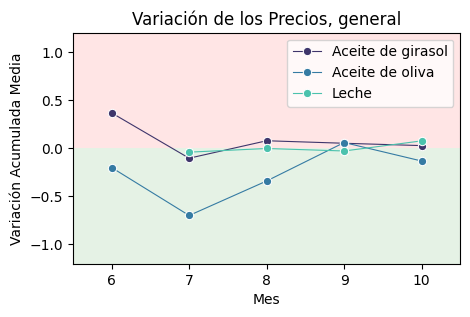

In [15]:
query = '''with variacion_acumulada as(
select extract (month from r.fecha) as mes,
				p.id_producto, s.id_categoria, 
				p.id_supermercado,
				sum(r.var_abs) as variacion_ac
from registros r 
inner join productos p on p.id_producto = r.id_producto 
inner join subcategorias s on s.id_subcat = p.id_subcat
group by mes, p.id_producto, s.id_categoria, p.id_supermercado
order by id_producto
)
select mes, c.nombre, avg(variacion_ac), id_supermercado
from variacion_acumulada va
inner join categorias c on c.id_categoria = va.id_categoria
group by c.nombre, mes, id_supermercado
order by id_supermercado,c.nombre, mes'''

conexion = conectar()
result = pd.DataFrame(query_fetch(conexion, query))
result.rename(columns=dict(enumerate(["mes", "categoria", "variacion_acum_media", "id_supermercado"])), inplace=True)
result["variacion_acum_media"] = result["variacion_acum_media"].apply(lambda x:round(x, ndigits=3))

plt.figure(figsize=(5,3), dpi = 100)
plt.title("Variación de los Precios, general")
sns.lineplot(result, x = "mes", y="variacion_acum_media", hue = "categoria", errorbar=None,
             marker = "o", palette = "mako", lw = 0.8,)
plt.xticks(np.arange(min(result["mes"]), max(result["mes"])+1, 1))
plt.ylabel('Variación Acumulada Media')
plt.xlabel('Mes')
plt.ylim(-1.2,1.2)
plt.xlim(5.5,10.5)
plt.axvspan(xmin = 5, xmax = 11,ymin = -1, ymax=0.5, facecolor = "green", alpha = 0.1)
plt.axvspan(xmin = 5, xmax = 11,ymin = 0.5, ymax=1, facecolor = "red", alpha = 0.1)
plt.legend()
plt.show()

Vemos que en julio se produjo una bajada general de los precios de aceites, y posteriormente el de girasol vio un ligero aumento de precios que perduró hasta este mes. Por otro lado, el aceite de oliva mantuvo unas bajadas (cada vez menores), hasta septiembre, donde aumentó de precio, para luego volver a bajar en octubre. Por último la leche se mantiene en un precio, observando ligeras subidas y bajadas a lo largo de los meses.

También podemos realizar el mismo análisis por supermercado:

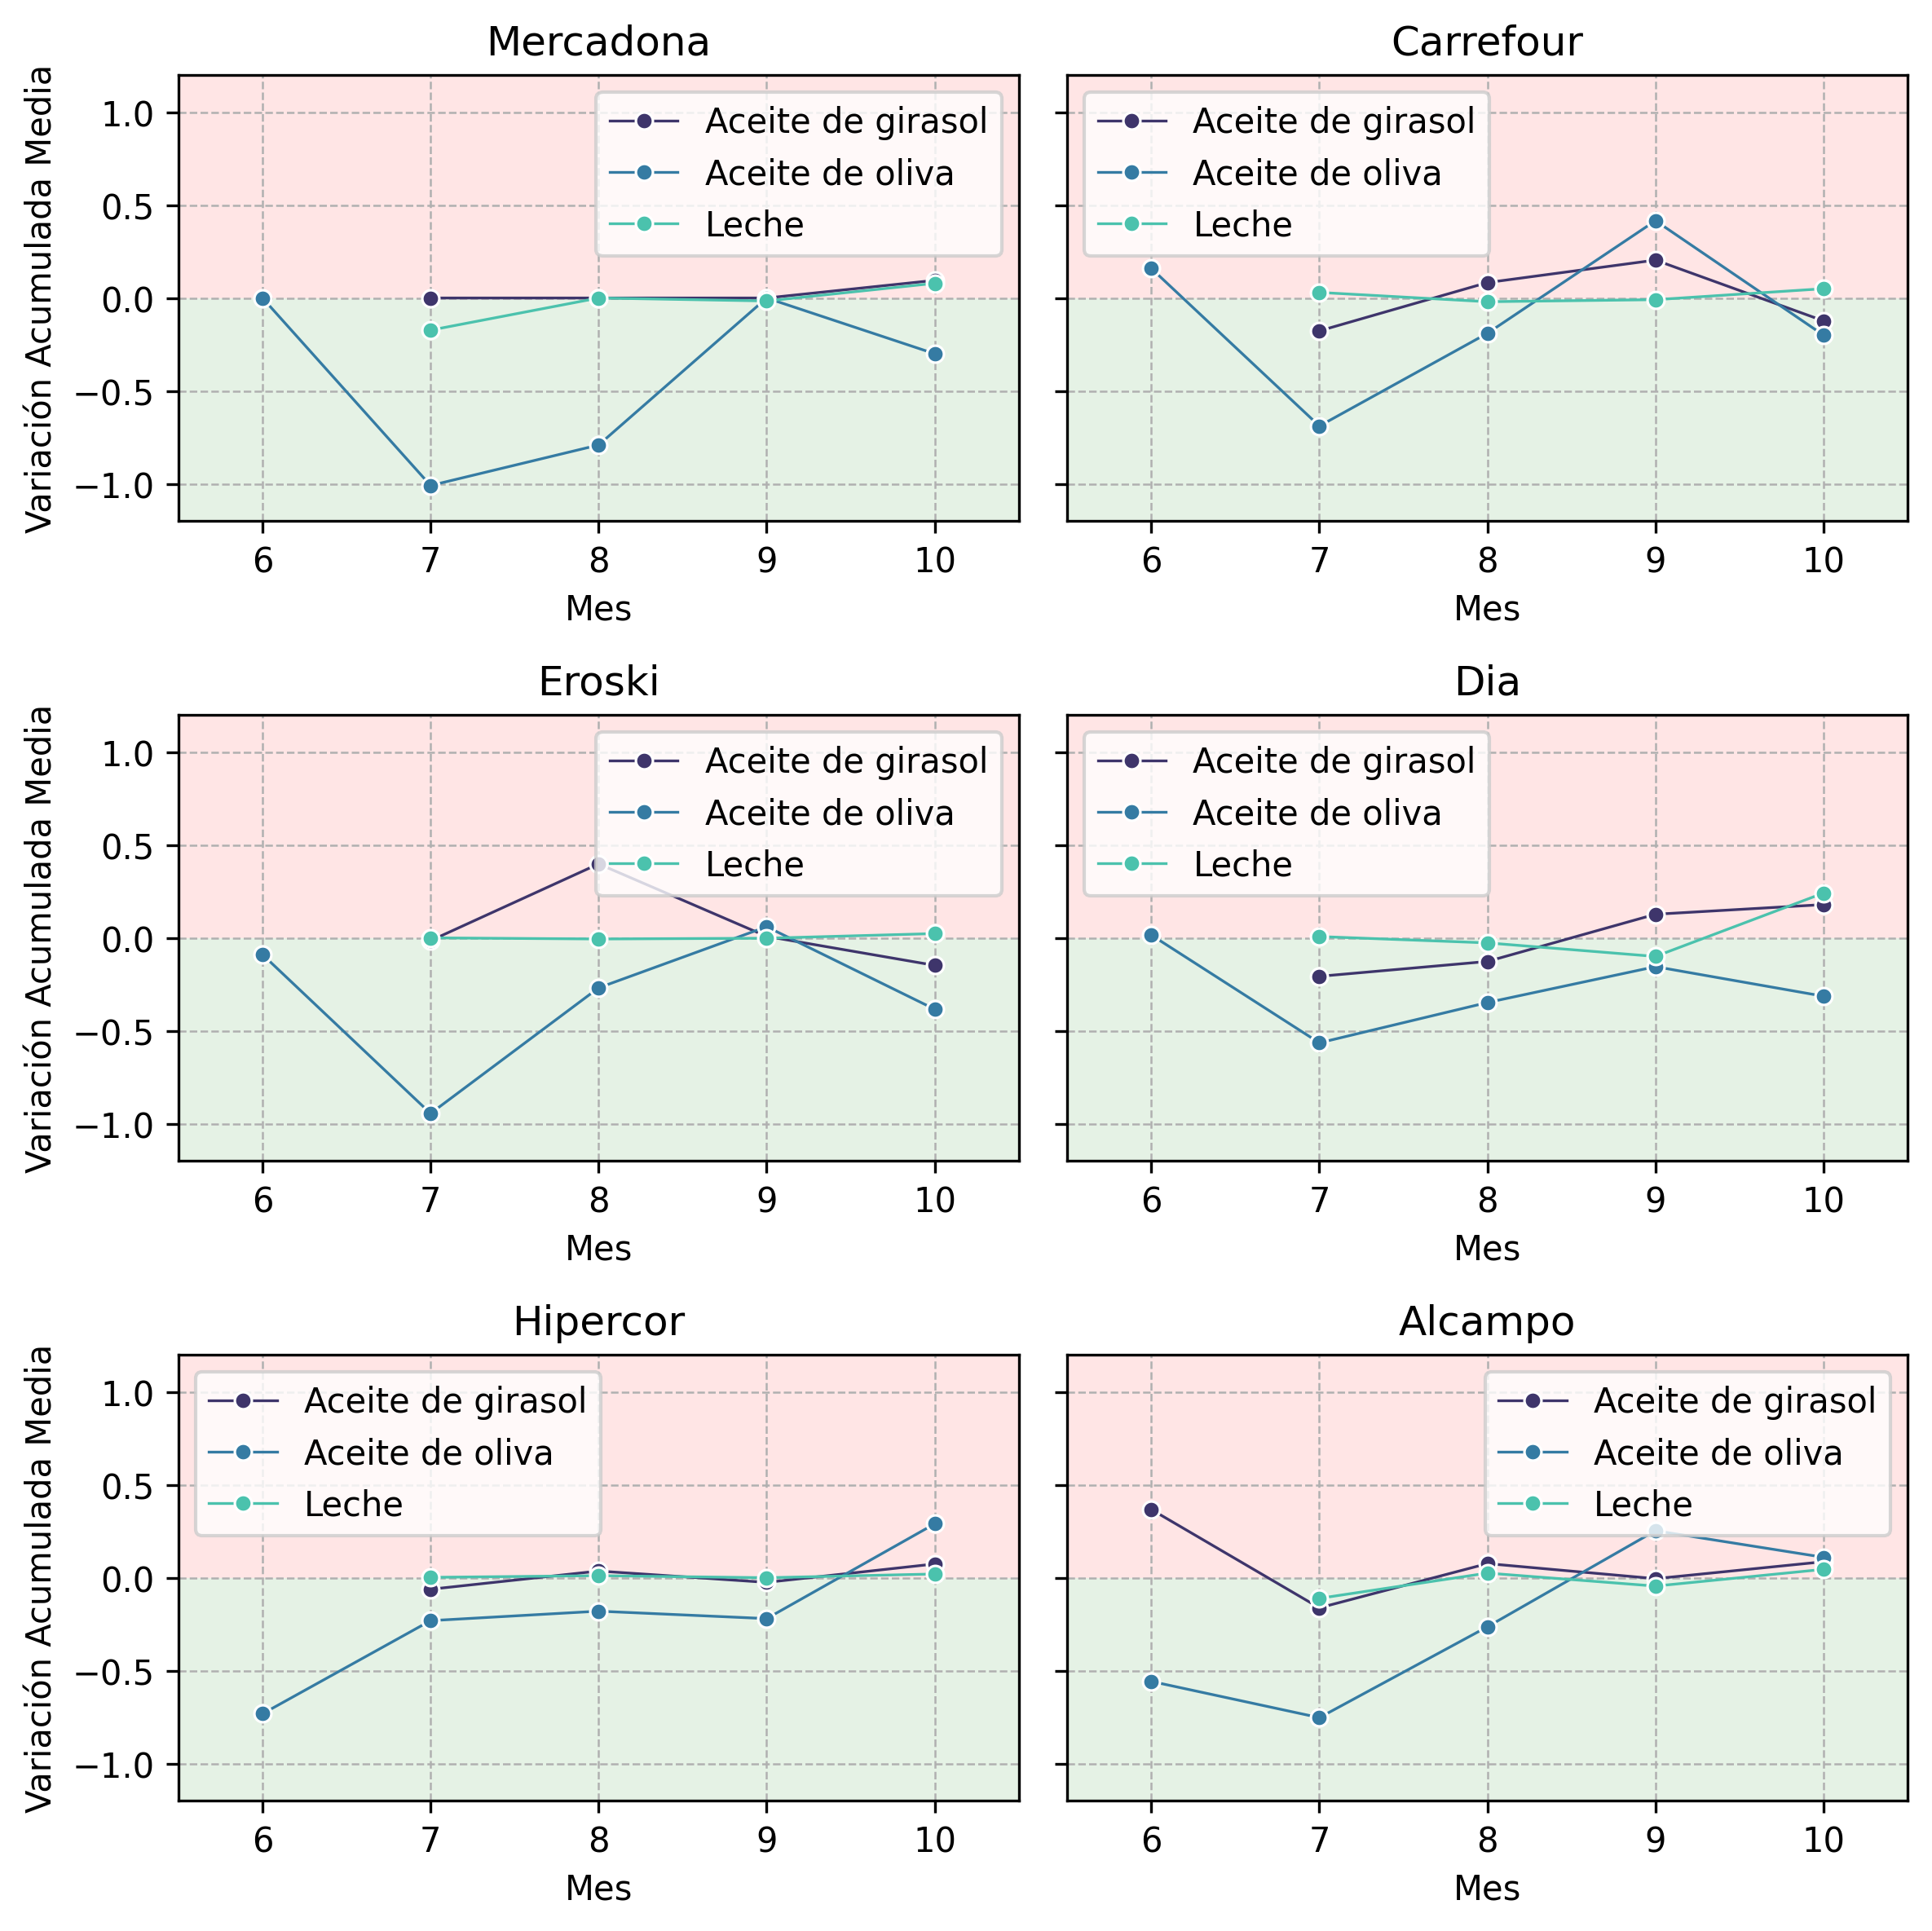

In [16]:
query = '''with variacion_acumulada as(
select extract (month from r.fecha) as mes,
				p.id_producto, s.id_categoria, 
				p.id_supermercado,
				sum(r.var_abs) as variacion_ac
from registros r 
inner join productos p on p.id_producto = r.id_producto 
inner join subcategorias s on s.id_subcat = p.id_subcat
group by mes, p.id_producto, s.id_categoria, p.id_supermercado
order by id_producto
)
select mes, c.nombre, avg(variacion_ac), s.nombre as supermercado
from variacion_acumulada va
inner join categorias c on c.id_categoria = va.id_categoria
inner join supermercado s on va.id_supermercado = s.id_supermercado
group by c.nombre, mes, s.id_supermercado 
order by s.id_supermercado ,c.nombre, mes'''

conexion = conectar()
result = pd.DataFrame(query_fetch(conexion, query))
result.rename(columns=dict(enumerate(["mes", "categoria", "variacion_acum_media", "id_supermercado"])), inplace=True)
result["variacion_acum_media"] = result["variacion_acum_media"].apply(lambda x: round(x, ndigits=3))

supermercados = result['id_supermercado'].unique()


fig, axes = plt.subplots(3, 2, figsize=(8,8), sharey=True, dpi = 300)
axes = axes.flatten()

for i, supermercado in enumerate(supermercados):
    df_supermercado = result[result['id_supermercado'] == supermercado]
    axes[i].grid(lw = 0.6, ls = "--")
    sns.lineplot(data=df_supermercado, x="mes", y="variacion_acum_media", hue="categoria", errorbar=None,
                 marker="o", palette = "mako", lw = 0.8, markersize = 5, ax=axes[i])
    axes[i].axvspan(xmin = 5, xmax = 11,ymin = -1, ymax=0.5, facecolor = "green", alpha = 0.1)
    axes[i].axvspan(xmin = 5, xmax = 11,ymin = 0.5, ymax=1, facecolor = "red", alpha = 0.1)
    axes[i].set_title(f'{supermercado}'.capitalize())
    axes[i].set_ylim(-1.2,1.2)
    axes[i].set_xlim(5.5,10.5)
    axes[i].set_xlabel("Mes")
    axes[i].set_ylabel("Variación Acumulada Media")
    axes[i].legend()

plt.tight_layout()
plt.show()


En líneas generales, el patrón discutido previamente se mantiene, con el aceite de oliva habiendo bajado durante varios meses y presentando menor bajada de precio e incluso subidas en septiembre. 

El supermercado con menor variación (tanto positiva como negativa) fue hipercor.

La bajada general de los precios del aceite de oliva se debe a que a finales de junio de 2024 se aplicó una exención del IVA en este producto, lo cual produjo una caída en sus precios.

#### Detección de anomalías

Para este apartado, se han buscado valores de variación anómalos a lo largo del tiempo. Para ello se ha seguido un criterio de desviaciones estándar (sigmas), donde si una variación se aleja 3 sigmas de la media en su subcategoría, la consideraremos anómala.

In [17]:
query = '''with stats as (
    select id_subcat,
           avg(var_porc) as media_variacion,
           stddev(var_porc) as std_variacion
    from registros r
    inner join productos p on r.id_producto = p.id_producto
    group by id_subcat
)
select r.id_producto, r.fecha, r.precio, r.var_porc,
       s.media_variacion, s.std_variacion, s.id_subcat
from registros r
inner join productos p on r.id_producto = p.id_producto
inner join stats s on p.id_subcat = s.id_subcat
where abs(r.var_porc-s.media_variacion) >  3 * s.std_variacion
order by r.fecha desc, s.id_subcat;'''

conexion = conectar()
anomalias_df = pd.DataFrame(query_fetch(conexion, query), columns = ["id_producto", "fecha", "precio", "var_porc", "media_var", "std_var", "id_subcat"])
anomalias_df[["media_var", "std_var"]] = anomalias_df[["media_var", "std_var"]].map(lambda x: round(float(x), ndigits=4))

Para el análisis cogeremos algunas de las más relevantes, en concreto aquellas que presenten más de 9 variaciones anómalas.

In [18]:
conteo_anom = anomalias_df.groupby("id_producto")["fecha"].count().reset_index()
id_productos = conteo_anom[conteo_anom["fecha"]>9]["id_producto"].values

Los productos que cumplen este criterio son los siguientes:

In [19]:
id_productos

array([ 774,  891, 1175], dtype=int64)

Estos productos son concretamente:

In [20]:
query = '''select nombre from productos
where id_producto in (774, 891, 1175)'''
conexion = conectar()
query_fetch(conexion, query)

[('COOSUR aceite de oliva virgen extra garrafa 5 l en Hipercor',),
 ('ORO BAILEN aceite de oliva virgen extra Picual botella 500 ml en Hipercor',),
 ('KOIPESOL Aceite de girasol  garrafa de 5 l. en Alcampo',)]

Ahora obtenemos todos los registros que tenemos de estos productos.

In [21]:
query = '''select fecha, id_producto, precio from registros
where id_producto in (774, 891, 1175)'''
conexion = conectar()
registros_anomalos = pd.DataFrame(query_fetch(conexion, query), columns=["fecha", "id_producto", "precio"])
registros_anomalos["precio"] = registros_anomalos["precio"].astype(float)

Y veamos la evolución temporal del precio.

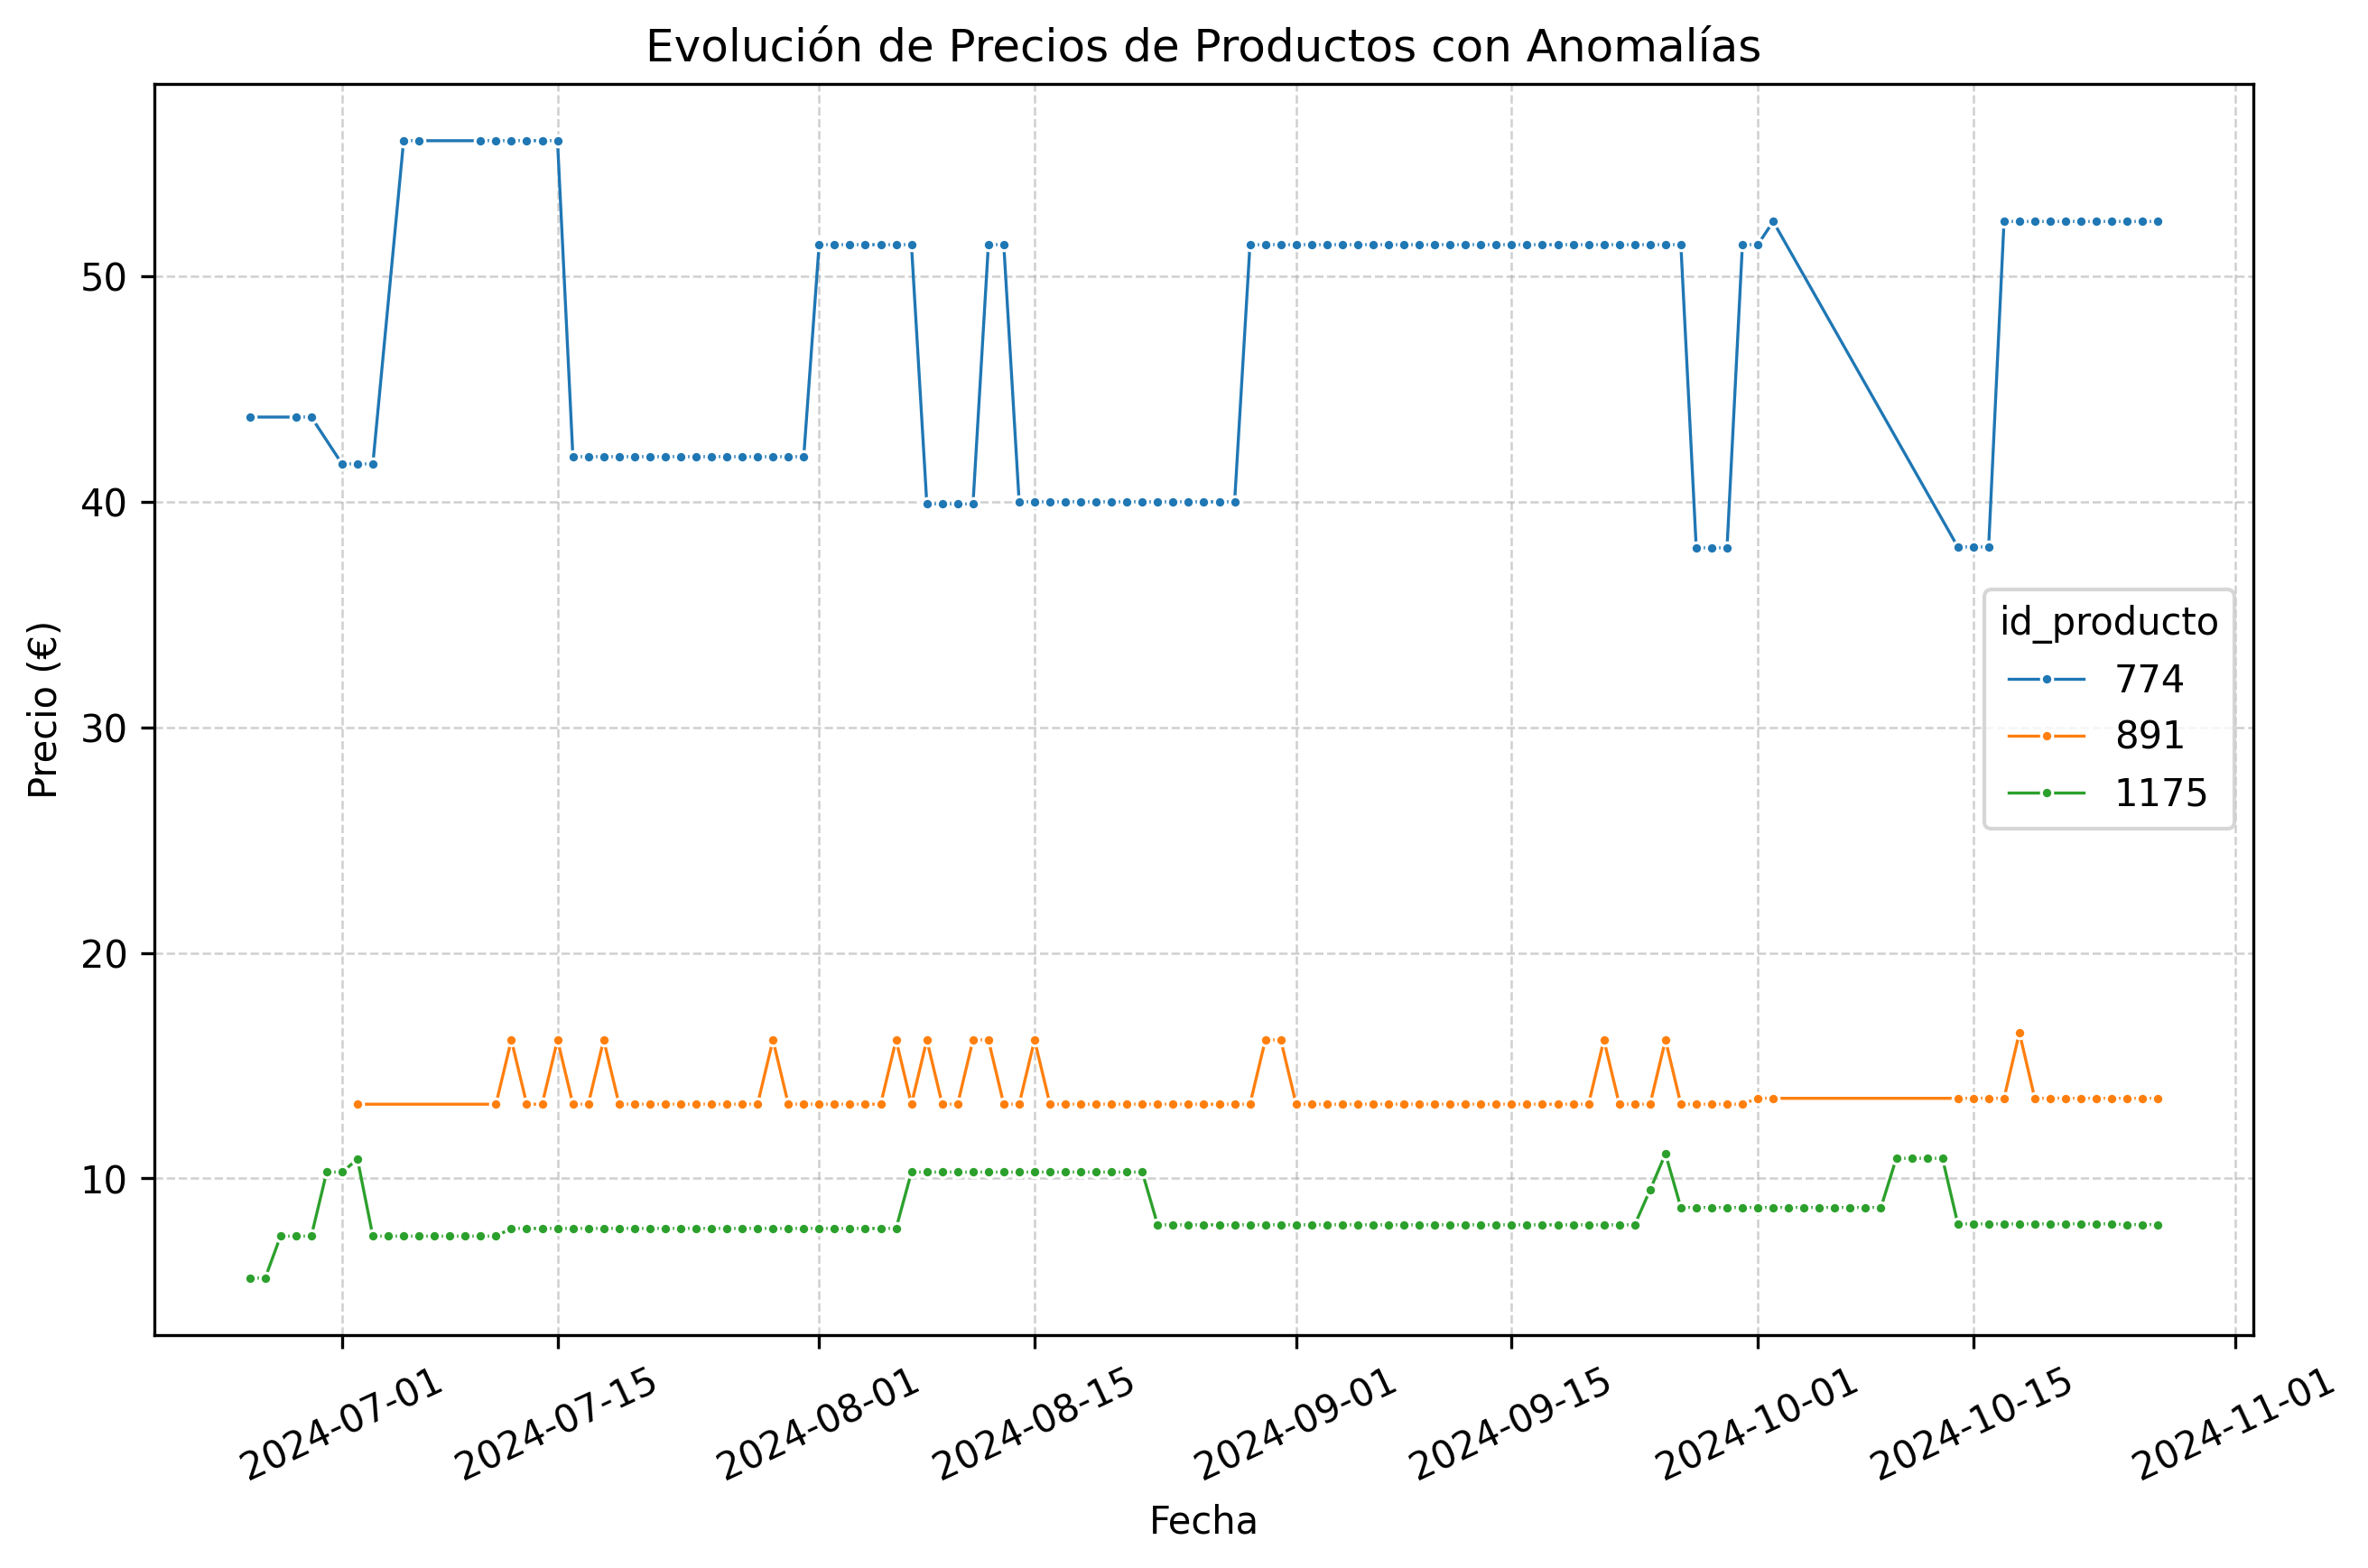

In [22]:
plt.figure(figsize=(10,6), dpi = 300)
plt.title("Evolución de Precios de Productos con Anomalías")
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)

sns.lineplot(registros_anomalos, x = "fecha", y = "precio", hue = "id_producto",
             palette = "tab10", marker = ".", lw = 0.8)

plt.xticks(rotation = 25)
plt.xlabel("Fecha")
plt.ylabel("Precio (€)")
plt.show()

A primera vista podríamos ver que simplemente hay subidas y bajadas, nada fuera de lo común. Sin embargo, cuando encontramos una subida de precio en un día, seguido de una bajada durante un periodo más largo, esto nos indica que el supermercado subió el precio un día, para luego poder marcarlo como rebajado en los siguientes. Esto ocurre en los tres productos ejemplificados en gráfica.

También podemos saber con mayor precisión el porcentaje de la bajada.

In [23]:
anomalias_df[anomalias_df["id_producto"] == 891].head()

,id_producto,fecha,precio,var_porc,media_var,std_var,id_subcat
100,891,2024-10-19,13.55,-17.68,0.0083,2.2975,4
103,891,2024-10-18,16.46,21.48,0.0083,2.2975,4
438,891,2024-09-26,13.29,-17.66,0.0083,2.2975,4
480,891,2024-09-25,16.14,21.44,0.0083,2.2975,4
512,891,2024-09-22,13.29,-17.66,0.0083,2.2975,4


Como por ejemplo para el producto 891, correspondiente a 'ORO BAILEN aceite de oliva virgen extra Picual botella 500 ml en Hipercor', presenta unas presuntas bajadas de precio de alrededor de un 18%, lo cual no es realista para el consumidor, ya que el precio fue subido momentáneamente para poder considerarlo una rebaja al día siguiente.

#### Análisis de dispersión de precios

Apoyándonos en el análisis de los precios realizado previamente, podemos sacar algunas conclusiones sobre la dispersión de precios en los diferentes supermercados.

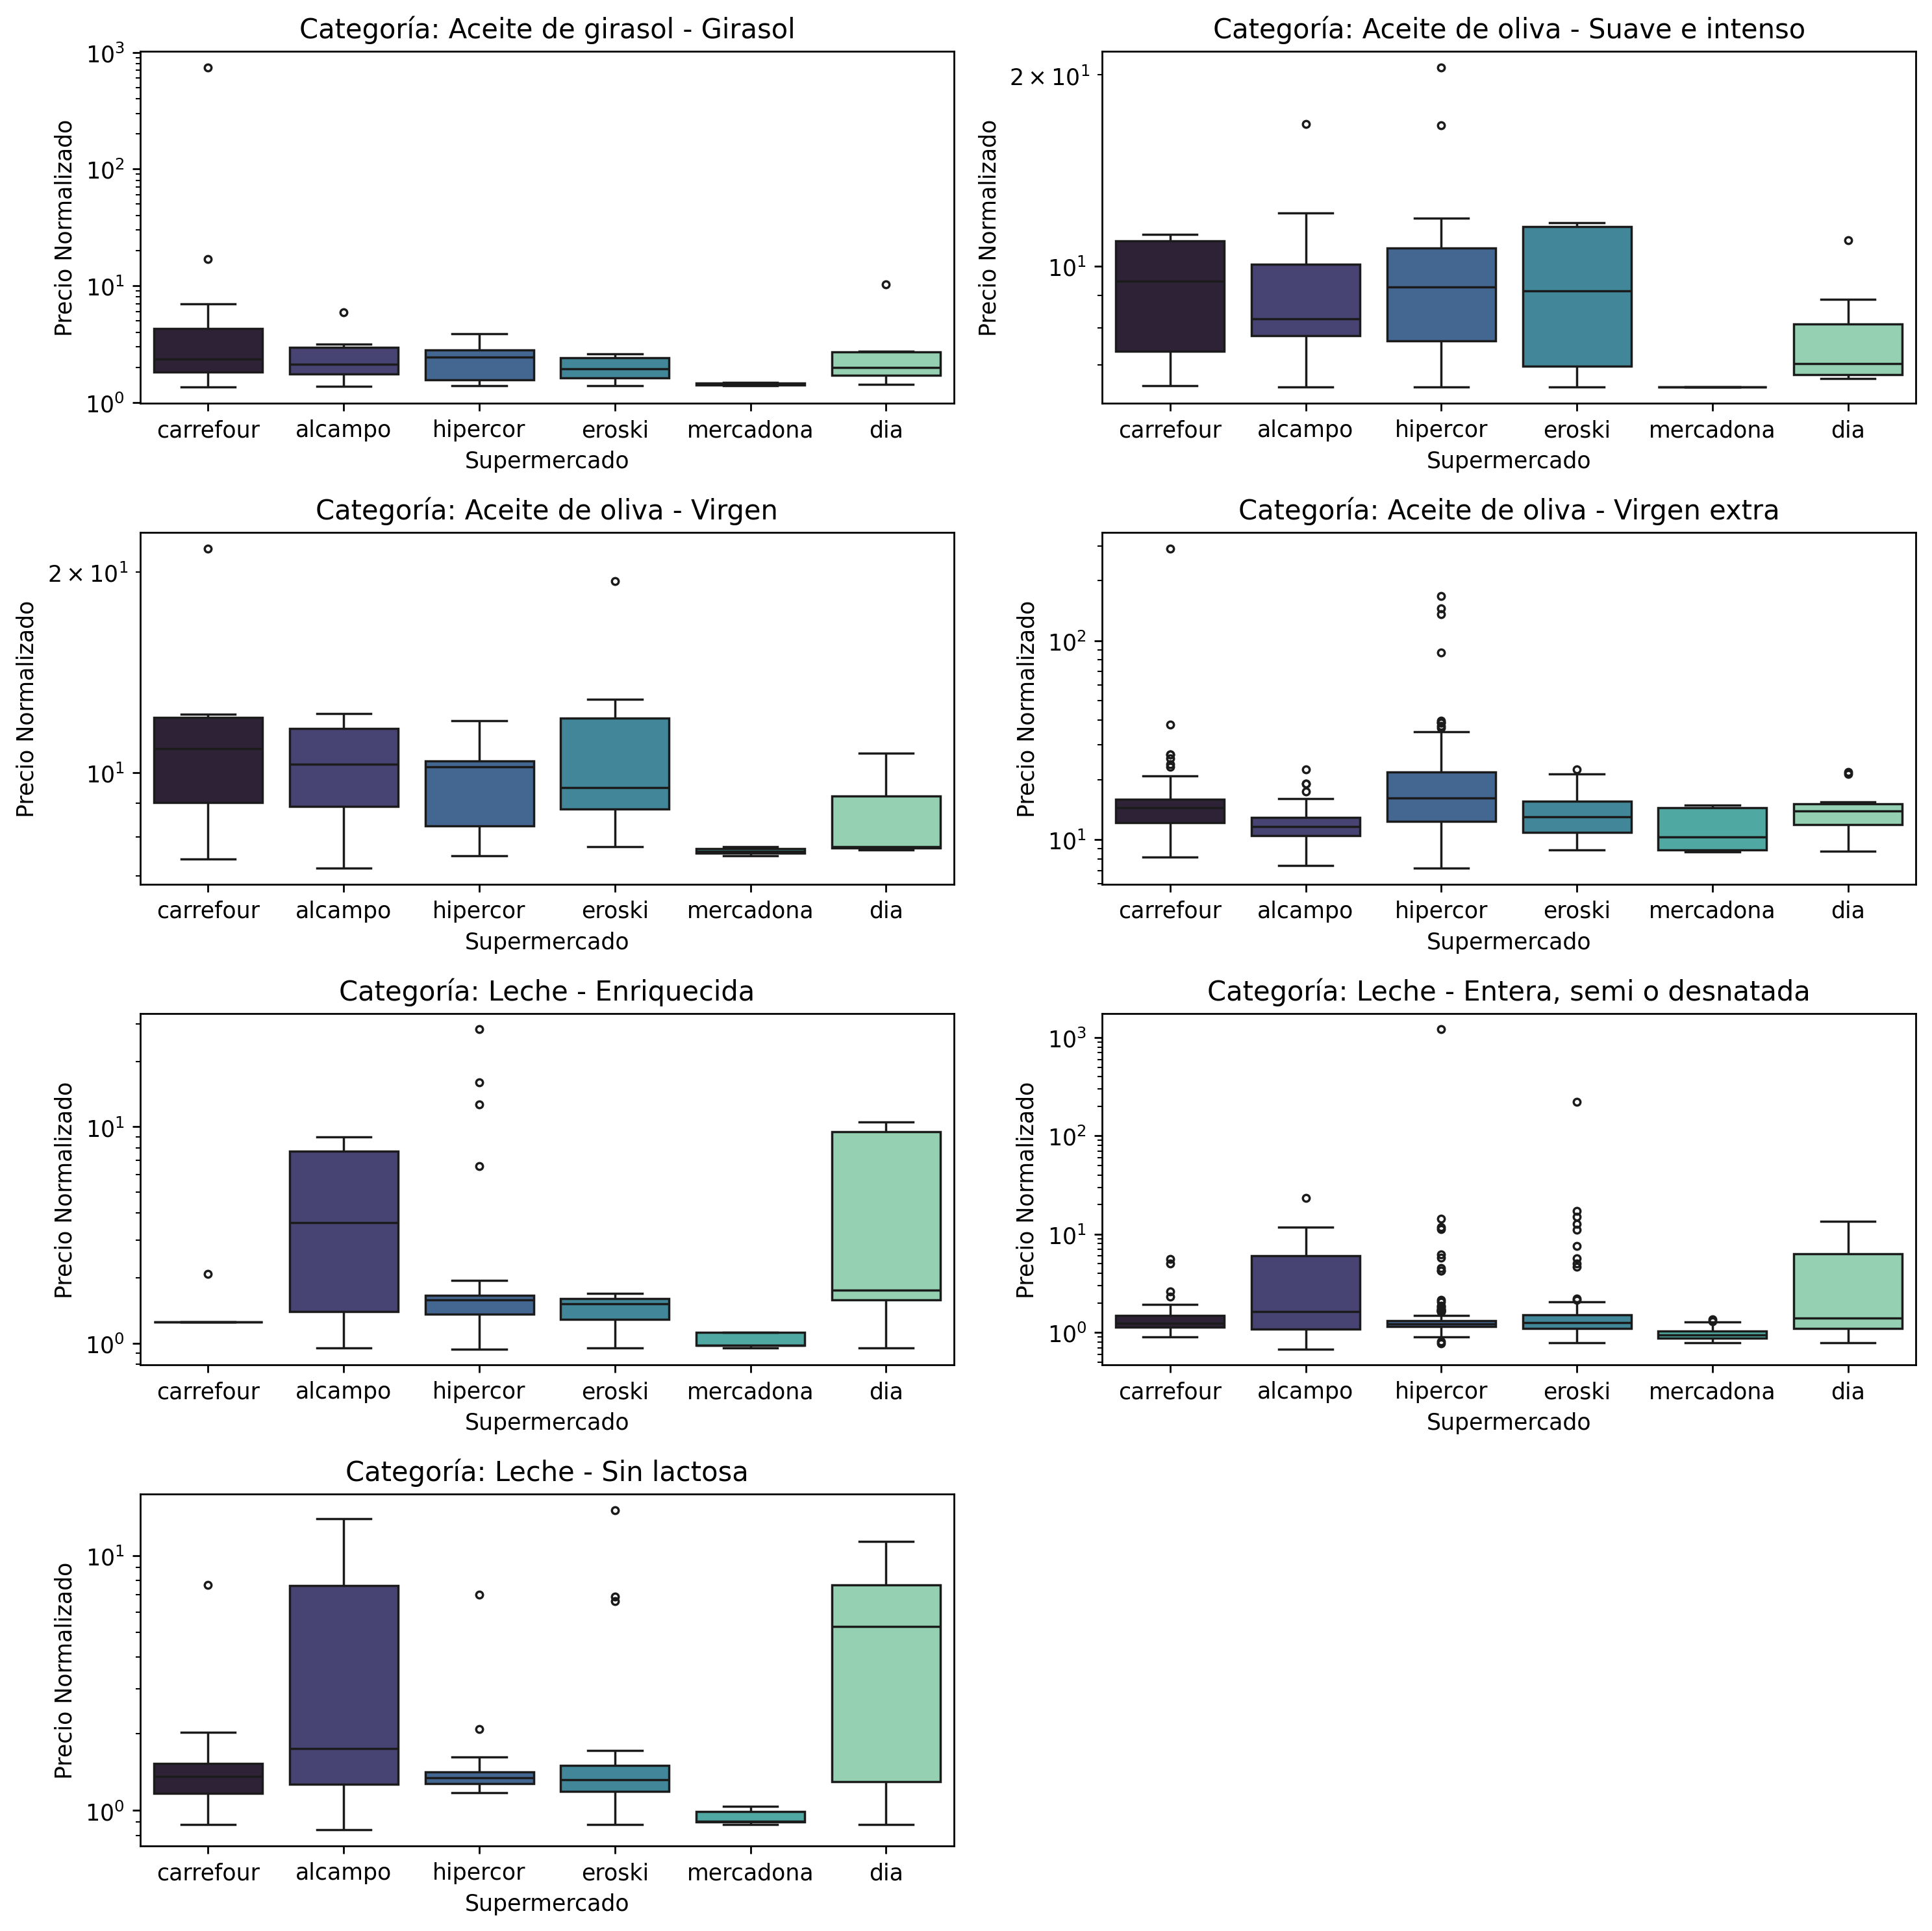

Como se ha mencionado previamente, el supermercado que presenta la menor dispersión en los precios es Mercadona, la cual posee la menor variedad de productos, lo cual podría ser adecuado para aquellos clientes que valoren la simplicidad y más previsibilidad a la hora de realizar la compra.

Para el resto de supermercados, se presentan dos casos:

- **Dispersión alta, pocos valores atípicos**: indica que tienen una variedad de productos homogénea para cada gama de precio, lo cual puede estar relacionado con una amplia gama de productos de marca propia, complementada con algunas adiciones de marcas externas, lo que resulta en precios más uniformes a través de diferentes categorías, o simplemente una homogeneidad de precios en las diferentes gamas, sin importar la marca.

- **Dispersión baja, muchos valores atípicos**: en este caso tenemos un tipo de supermercado con productos con precios mayoritariamente estables, mientras que hay algunos productos que se devían significativamente, lo cual puede indicar una estrategia de naturaleza competitiva, donde se ofrecen productos del día a día con buenos precios, pero manteniendo una sección de productos más premium para aquellos clientes que buscan algo de mayor calidad.


#### Comparación de precios promedio

Aprovechando los datos obtenidos en previos análisis, vamos a realizar una comparación de precios promedio por subcategoría de productos. Sabiendo que los valores atípicos son datos recogidos erróneamente, podremos tomarnos la libertad de omitirlos en este análisis, para que no afecten al cálculo de la media.

In [24]:
indices_outliers = []
for supermercado in precios_ps["supermercado"].unique():
    for subcat in precios_ps["subcategoria"].unique():
        indices_outliers.extend(get_outliers_especificos(precios_ps, supermercado, subcat).index)

precios_ps_no_outliers = precios_ps.drop(index=indices_outliers)

In [25]:
medias_precios_norm = precios_ps_no_outliers.groupby(["categoria","subcategoria", "supermercado"])["precio_norm"].mean()

In [26]:
medias_precios_norm.reset_index().sample(5)

,categoria,subcategoria,supermercado,precio_norm
0,Aceite de girasol,Girasol,alcampo,2.188000
17,Aceite de oliva,Virgen,mercadona,7.625000
29,Leche,Enriquecida,mercadona,1.030000
15,Aceite de oliva,Virgen,eroski,9.841667
25,Leche,Enriquecida,carrefour,1.250000


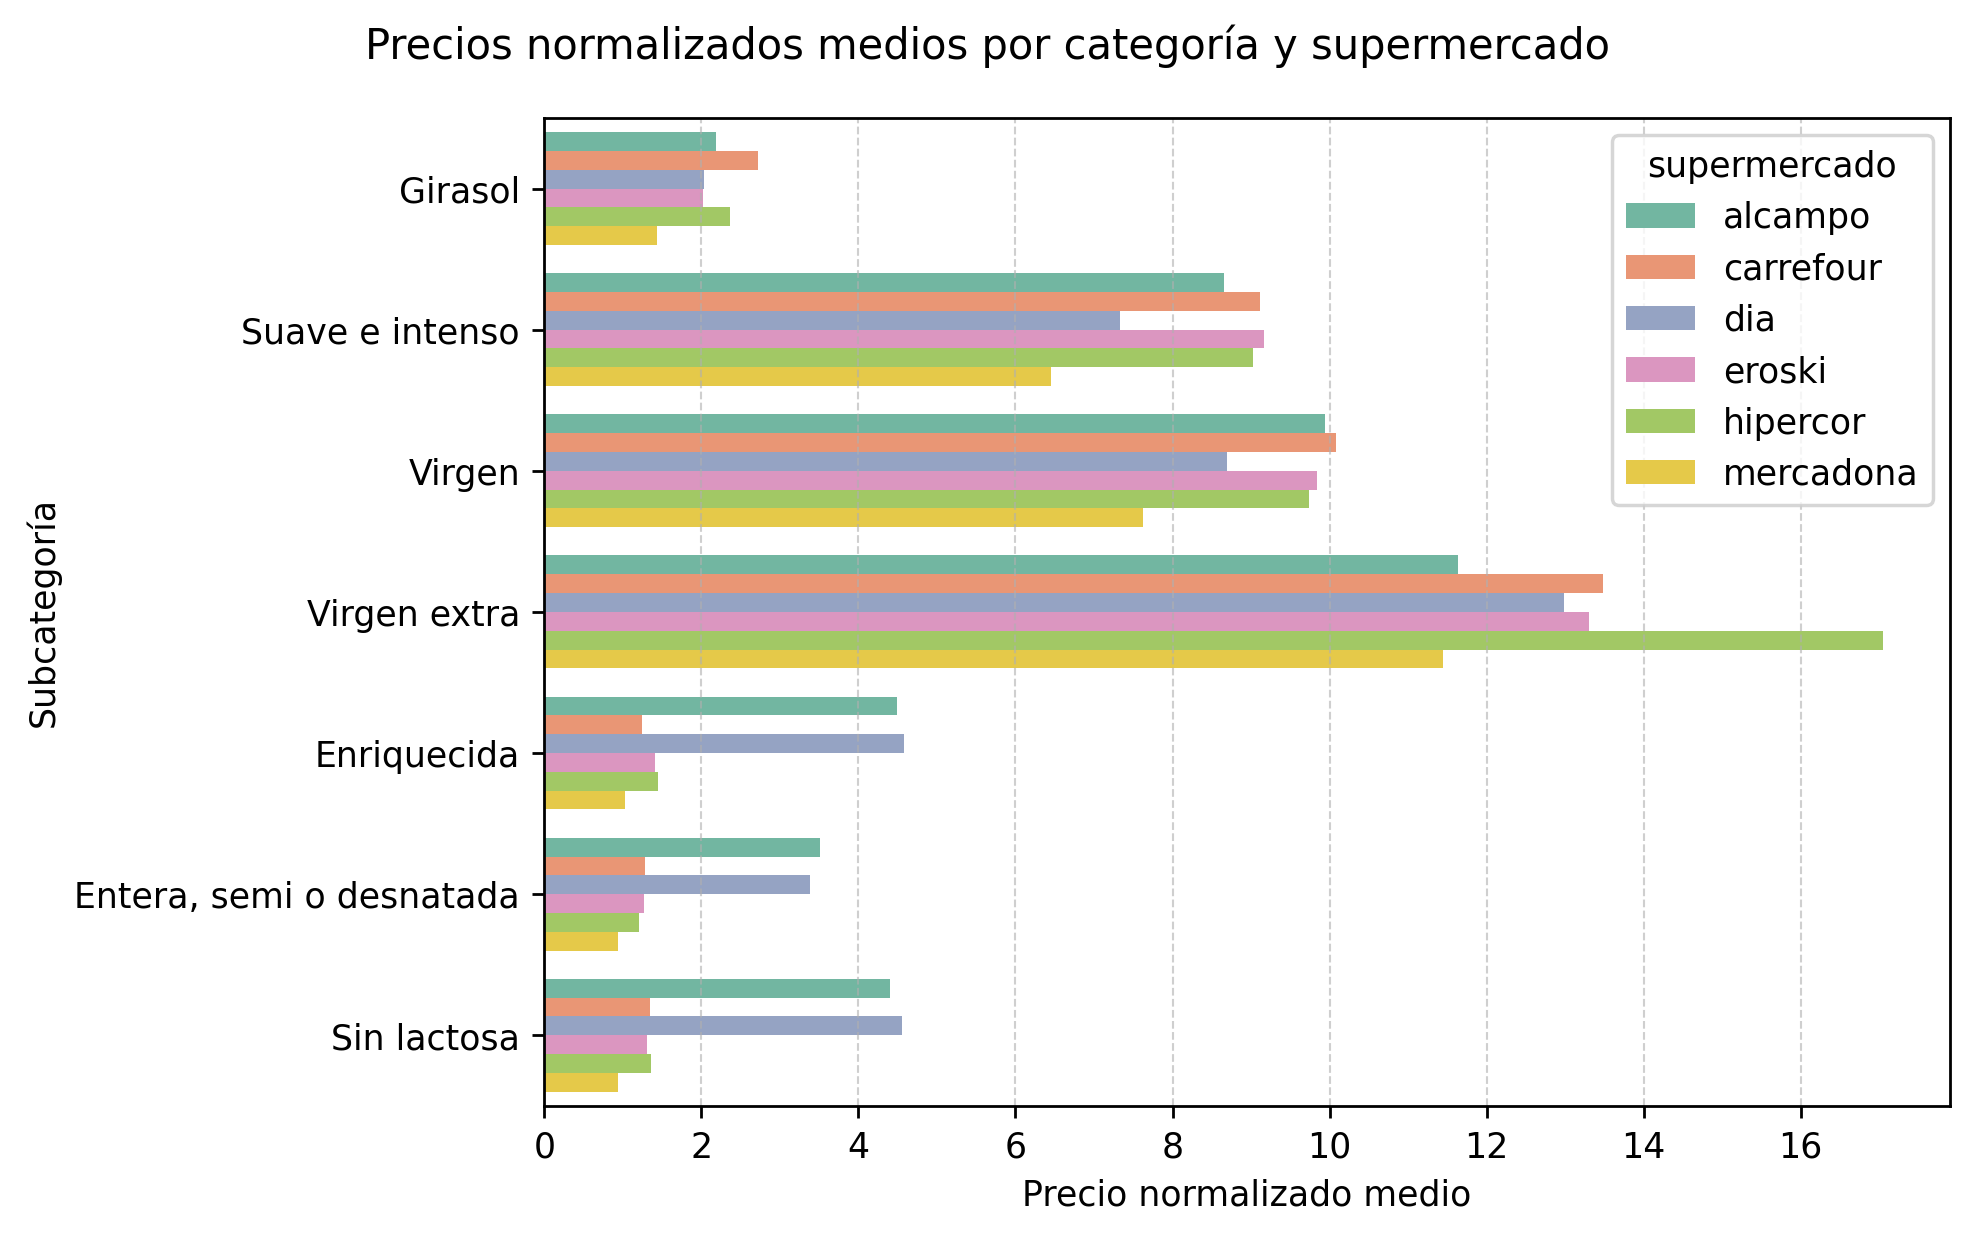

In [27]:
plt.figure(figsize=(8,5), dpi = 250)
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
plt.suptitle("Precios normalizados medios por categoría y supermercado")
sns.barplot(medias_precios_norm.reset_index(), y = "subcategoria", x = "precio_norm", 
            hue = "supermercado", palette="Set2")
plt.xlabel("Precio normalizado medio")
plt.ylabel("Subcategoría")
plt.tight_layout()
plt.show()

Vemos que el Mercadona suele ser el que ofrece los precios más atractivos a lo largo de todos los tipos de productos. Como se ha mencionado previamente, esto lo logra ofreciendo principalmente su propia marca, lo cual permite a la cadena tener precios más bajos con respecto a la competencia, la cual, además de ofrecer sus propias marcas, ofrece marcas externas, las cuales podrían resultar opciones más atractivas según el consumidor.

También cabe destacar una posible anomalía en los datos. Si nos fijamos en los precios de los productos lácteos (Enriquecida, Entera semi o desnatada y Sin lactosa), apreciamos un precio medio más alto en supermercados como Dia y Alcampo, los cuales tienen precios medios para estos productos de alrededor de 4 €.

In [28]:
productos_pack = precios_ps[precios_ps["nombre_producto"].str.contains(pat = "\d+\s?x\s?\d+")]
productos_pack["supermercado"].value_counts()

supermercado
alcampo    78
dia        39
eroski      8
Name: count, dtype: int64

In [29]:
productos_pack["categoria"].value_counts()

categoria
Leche    125
Name: count, dtype: int64

Vemos que de los productos de tipo pack (es decir N x N ud.), se encuentran principalmente en dia y alcampo. Estos datos no fueron tenidos en cuenta en la limpieza de datos, por lo que si un valor presentaba un nombre como 'Leche desnatada pack 3 x 1L', en los datos aparecerá como 1L.

In [30]:
indices_pack = precios_ps_no_outliers[precios_ps_no_outliers["nombre_producto"].str.contains(pat = "\d+\s?x\s?\d+")].index

In [31]:
precios_ps_no_outliers2 = precios_ps_no_outliers.drop(index = indices_pack)
medias_precios_norm2 = precios_ps_no_outliers2.groupby(["categoria","subcategoria", "supermercado"])["precio_norm"].mean()

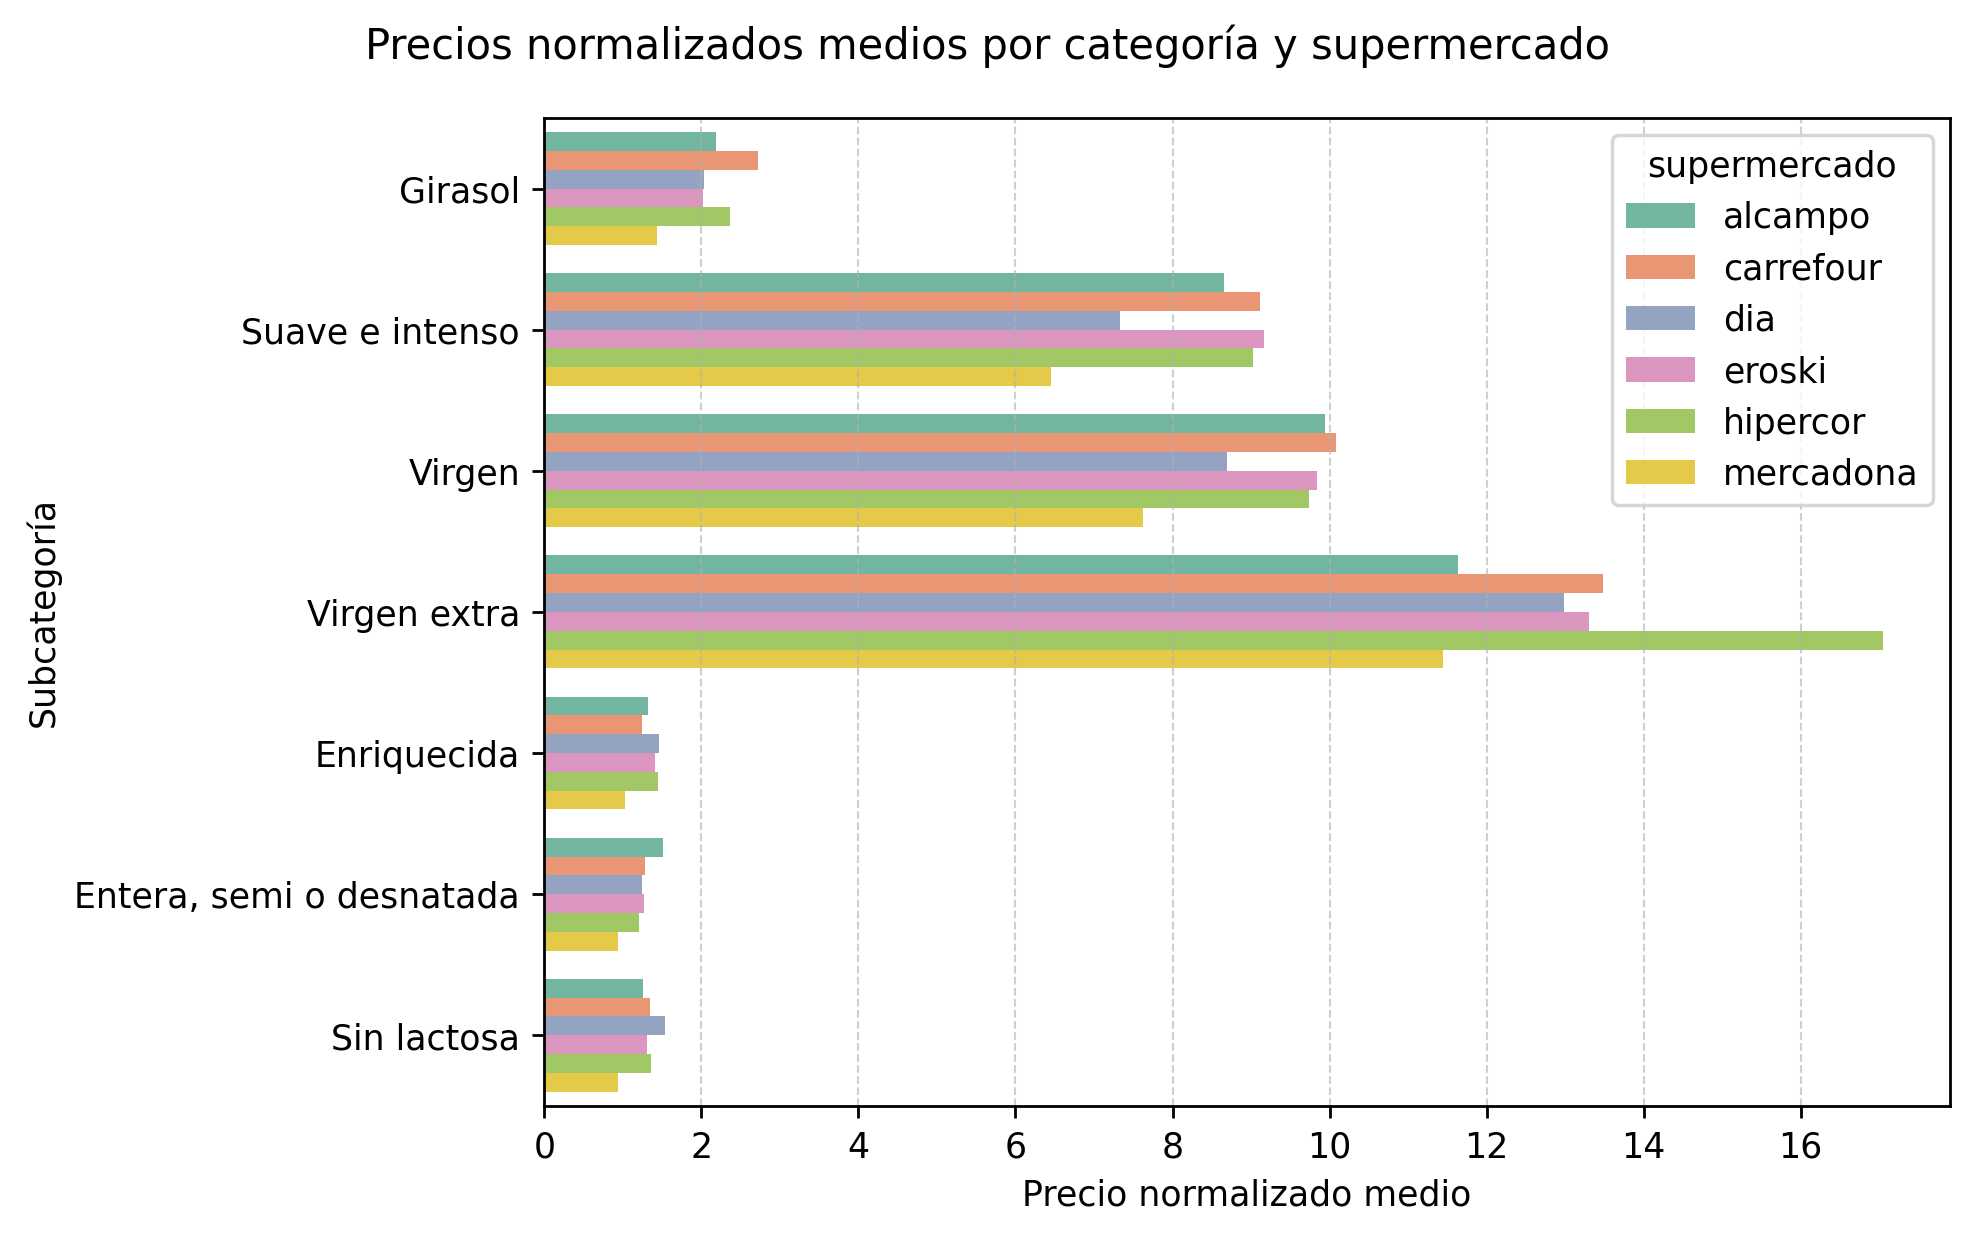

In [32]:
plt.figure(figsize=(8,5), dpi = 250)
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
plt.suptitle("Precios normalizados medios por categoría y supermercado")
sns.barplot(medias_precios_norm2.reset_index(), y = "subcategoria", x = "precio_norm", 
            hue = "supermercado", palette="Set2")
plt.xlabel("Precio normalizado medio")
plt.ylabel("Subcategoría")
plt.tight_layout()
plt.show()

Tras limpiar esos datos que generaban ruido, vemos cómo los precios de productos lácteos entre supermercados son mucho más cercanos.